In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import esda
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pyrosm
import contextily as cx 
from shapely.geometry import Point

from pysal.lib import weights
from splot.libpysal import plot_spatial_weights

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.__version__

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
/opt/conda/lib/python3.9/site-packages/esda/getisord.py:636: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if __name__ is "__main__":


'1.1.2'

In [4]:
#filename = "data/20-04-23.csv"
filename = "data/boligsiden.csv"

In [5]:
pd.read_csv(filename)

,Sagsnr,available_from,rooms,area,rent,per_area_price,address,zip_code,latitude,longitude
0,KK-FA076(2521),2023-02-15,5.0,118.0,17907,455.0,"Richard Mortensens Vej 27L, 2300 København S",2300,55.621580,12.572253
1,KK-FO021(2521),2022-05-01,2.0,65.0,11419,527.0,"Richard Mortensens Vej 25A, 4. tv, 2300 Københ...",2300,55.621788,12.572034
2,199500004381995004,2022-04-27,2.0,78.0,12000,462.0,"Ørestads Boulevard 63E, st. th, 2300 København S",2300,55.632766,12.582294
3,11802696,2022-06-01,4.0,142.0,23075,488.0,"Linnésgade 22C, 3. tv, 1361 København K",1361,55.684372,12.571401
4,11802617,2022-04-15,3.0,117.0,15500,397.0,"Sundby Parkvej 2, st. th, 2300 København S",2300,55.662417,12.630089
...,...,...,...,...,...,...,...,...,...,...
2234,1770011681177hom,2023-04-05,2.0,52.0,11200,646.0,"Søndre Fasanvej 90, 2., 2500 Valby",2500,55.667692,12.516677
2235,1770011680177hom,2023-04-05,1.0,32.0,7800,731.0,"Gammel Jernbanevej 29, 1., 2500 Valby",2500,55.663920,12.518249
2236,1770011682177hom,2023-04-05,4.0,104.0,15400,444.0,"Else Alfelts Vej 66D, 2. tv, 2300 København S",2300,55.619356,12.568378
2237,101563_270216,2023-07-01,4.0,121.0,17300,429.0,"Gammel Køge Landevej 20C, 2500 Valby",2500,55.660193,12.515014


In [6]:
17907/118

151.75423728813558

In [7]:
#df = pd.read_csv(filename, names=["id", "rooms", "area", "rent", "street", "zip_code", "latitude", "longitude"], skiprows=1)
df = pd.read_csv(filename, names=["id", "available_from", "rooms", "area", "rent", "per_area_price", "address", "zip_code", "latitude", "longitude"], skiprows=1)

In [8]:
df.columns

Index(['id', 'available_from', 'rooms', 'area', 'rent', 'per_area_price',
       'address', 'zip_code', 'latitude', 'longitude'],
      dtype='object')

# Data anomalities

In [9]:
# Drop 0 latitude / longitude:
df.drop(df[df.latitude == 0].index, inplace=True)
df.drop(df[df.longitude == 0].index, inplace=True)

In [10]:
# Uniqueness
duplicates = df.duplicated(subset=['id'])
duplicates_df = df[duplicates]

In [11]:
# Get number of duplicates
duplicates.value_counts()

False    2239
dtype: int64

In [12]:
df["id"].value_counts()

KK-FA076(2521)      1
1770010789177009    1
1770010788177009    1
1770010790177009    1
1770010792177009    1
                   ..
1770009457177009    1
1770009456177009    1
1770009455177009    1
1770009454177009    1
1770011683177hom    1
Name: id, Length: 2239, dtype: int64

In [13]:
# Display the duplicates - Note: They are not necessarily duplicates as street/door numnber is not included.
#duplicates_df.sort_values(by=['street', 'area'])
df.sort_values(by=['id'])

,id,available_from,rooms,area,rent,per_area_price,address,zip_code,latitude,longitude
1703,1770011121177hom,2023-02-24,1.0,44.0,8900,607.0,"Søndre Fasanvej 90, 4. 418, 2500 Valby",2500,55.667692,12.516677
234,10-X00016093426001,2022-05-01,2.0,85.0,12600,445.0,"Asger Jorns Allé 8, 3. 1, 2300 København S",2300,55.619747,12.574259
219,10-X00016113426001,2022-05-01,3.0,102.0,13500,397.0,"Asger Jorns Allé 6, 5. 1, 2300 København S",2300,55.620013,12.574098
384,10-X00016853426001,2022-05-27,4.0,101.0,14500,431.0,"Ørestads Boulevard 49S, 6. 1, 2300 København S",2300,55.636141,12.582915
302,10-X00016873426001,2022-10-15,3.0,84.0,11500,411.0,"Richard Mortensens Vej 40, st. th, 2300 Københ...",2300,55.620700,12.570844
...,...,...,...,...,...,...,...,...,...,...
1659,86000000986col,2023-02-01,4.0,111.0,15250,412.0,"Kronprinsessegade 18B, 4., 1306 København K",1306,55.683531,12.582051
874,KK-009(2521),2022-12-01,2.0,65.0,12846,593.0,"Richard Mortensens Vej 25A, 3. tv, 2300 Københ...",2300,55.621788,12.572034
722,KK-012(2521),2022-10-01,2.0,65.0,11166,515.0,"Robert Jacobsens Vej 34, 1. tv, 2300 København S",2300,55.621437,12.573371
0,KK-FA076(2521),2023-02-15,5.0,118.0,17907,455.0,"Richard Mortensens Vej 27L, 2300 København S",2300,55.621580,12.572253


In [14]:
# Get number of nan values per columns
for col in df.columns:
    print(col)
    print(df[col].isnull().values.sum())

id
0
available_from
0
rooms
4
area
1
rent
0
per_area_price
1
address
0
zip_code
0
latitude
0
longitude
0


In [15]:
# Dataframe with nans dropped
df2 = df.dropna()

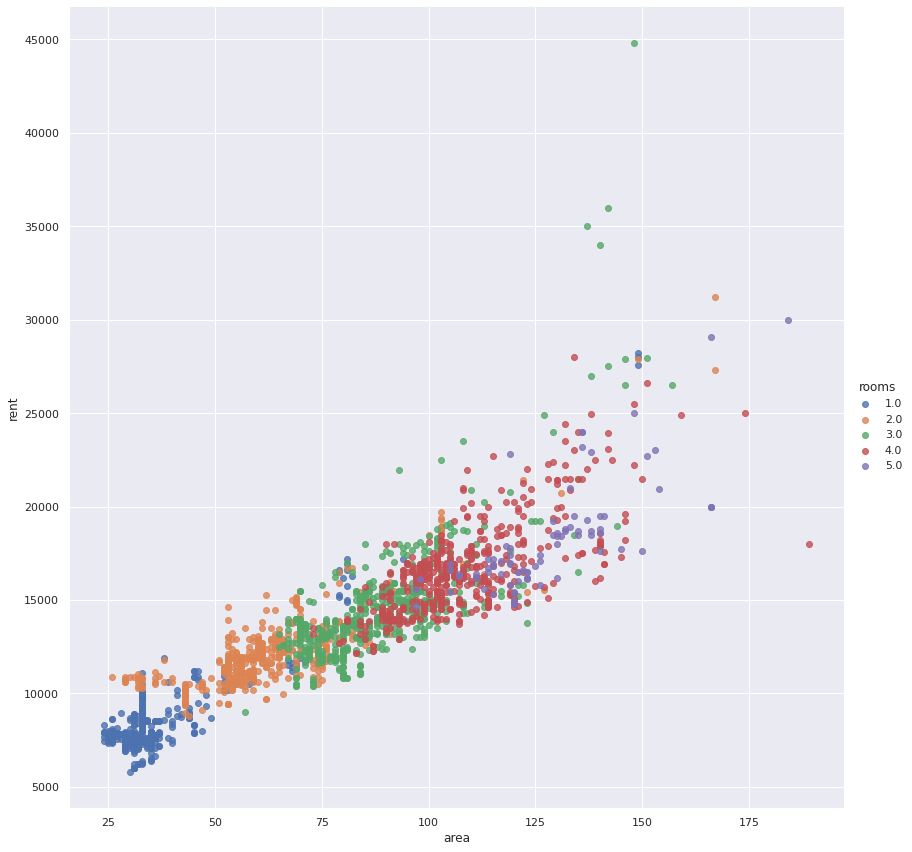

In [16]:
# Plotting 

import seaborn as sns

sns.set(rc={'figure.figsize':(26,12)})
sns.lmplot('area', 'rent', data=df2, hue='rooms', fit_reg=False, height=12, aspect=1)

plt.show()

# Data wrangling (normalize)

In [17]:
df2["rent_norm"] = df2["rent"] / df2["area"]

In [18]:
df2

,id,available_from,rooms,area,rent,per_area_price,address,zip_code,latitude,longitude,rent_norm
0,KK-FA076(2521),2023-02-15,5.0,118.0,17907,455.0,"Richard Mortensens Vej 27L, 2300 København S",2300,55.621580,12.572253,151.754237
1,KK-FO021(2521),2022-05-01,2.0,65.0,11419,527.0,"Richard Mortensens Vej 25A, 4. tv, 2300 Københ...",2300,55.621788,12.572034,175.676923
2,199500004381995004,2022-04-27,2.0,78.0,12000,462.0,"Ørestads Boulevard 63E, st. th, 2300 København S",2300,55.632766,12.582294,153.846154
3,11802696,2022-06-01,4.0,142.0,23075,488.0,"Linnésgade 22C, 3. tv, 1361 København K",1361,55.684372,12.571401,162.500000
4,11802617,2022-04-15,3.0,117.0,15500,397.0,"Sundby Parkvej 2, st. th, 2300 København S",2300,55.662417,12.630089,132.478632
...,...,...,...,...,...,...,...,...,...,...,...
2234,1770011681177hom,2023-04-05,2.0,52.0,11200,646.0,"Søndre Fasanvej 90, 2., 2500 Valby",2500,55.667692,12.516677,215.384615
2235,1770011680177hom,2023-04-05,1.0,32.0,7800,731.0,"Gammel Jernbanevej 29, 1., 2500 Valby",2500,55.663920,12.518249,243.750000
2236,1770011682177hom,2023-04-05,4.0,104.0,15400,444.0,"Else Alfelts Vej 66D, 2. tv, 2300 København S",2300,55.619356,12.568378,148.076923
2237,101563_270216,2023-07-01,4.0,121.0,17300,429.0,"Gammel Køge Landevej 20C, 2500 Valby",2500,55.660193,12.515014,142.975207


In [19]:
# Saving the file with added norm column
df2.to_csv(filename.split(".")[0] + "_norm" + ".csv")

# Geopandas

In [20]:
#geometry = gdp.points_from_xy(df2.longitude, df2.latitude, crs="EPSG:4326")
gdf = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude,df2.latitude, crs="EPSG:4326"))

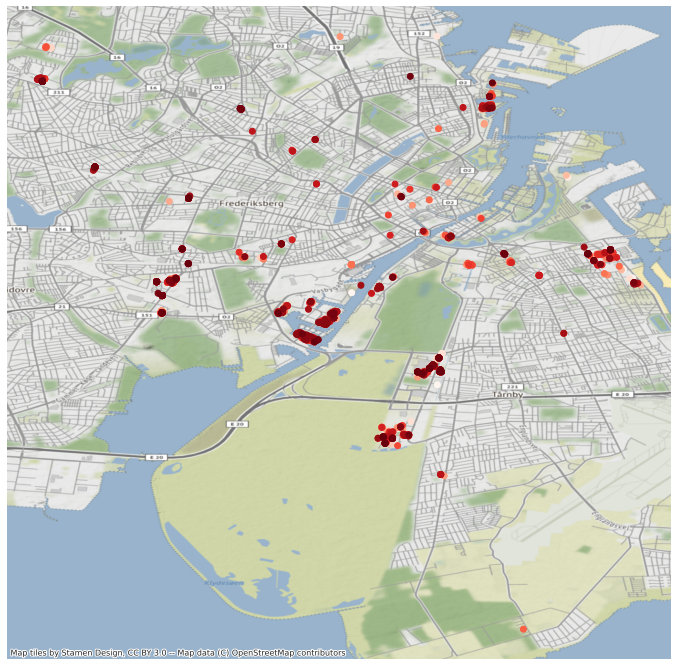

In [21]:
ax = gdf.plot(c=gdf["rent"], cmap='Reds', legend=True) #color="black")
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf.crs)

cmap = plt.cm.get_cmap('cool')
cmap.set_under('red')

# City Areas

In [18]:
cph_areas_bydel = gpd.read_file("data/bydel.geojson")

In [19]:
cph_areas_bydel

,id,bydel_nr,navn,areal_m2,ogc_fid,geometry
0,3,3,Nørrebro,4107620.0,1,"MULTIPOLYGON (((12.53704 55.69653, 12.53694 55..."
1,30,6,Vanløse,6699013.0,2,"MULTIPOLYGON (((12.49820 55.68552, 12.49845 55..."
2,32,7,Brønshøj-Husum,8740777.0,3,"MULTIPOLYGON (((12.46894 55.69975, 12.46935 55..."
3,10,10,Amager Vest,19364766.0,4,"MULTIPOLYGON (((12.58271 55.66850, 12.58252 55..."
4,2,2,Østerbro,9858727.0,5,"MULTIPOLYGON (((12.59777 55.70348, 12.59700 55..."
5,4,4,Vesterbro-Kongens Enghave,8327301.0,6,"MULTIPOLYGON (((12.54553 55.63972, 12.54677 55..."
6,31,5,Valby,9235110.0,7,"MULTIPOLYGON (((12.52434 55.66666, 12.52372 55..."
7,8,8,Bispebjerg,6830452.0,8,"MULTIPOLYGON (((12.53830 55.72644, 12.53822 55..."
8,9,9,Amager Øst,9800687.0,9,"MULTIPOLYGON (((12.63082 55.67057, 12.63079 55..."
9,1,1,Indre By,10471990.0,10,"MULTIPOLYGON (((12.72897 55.70386, 12.72899 55..."


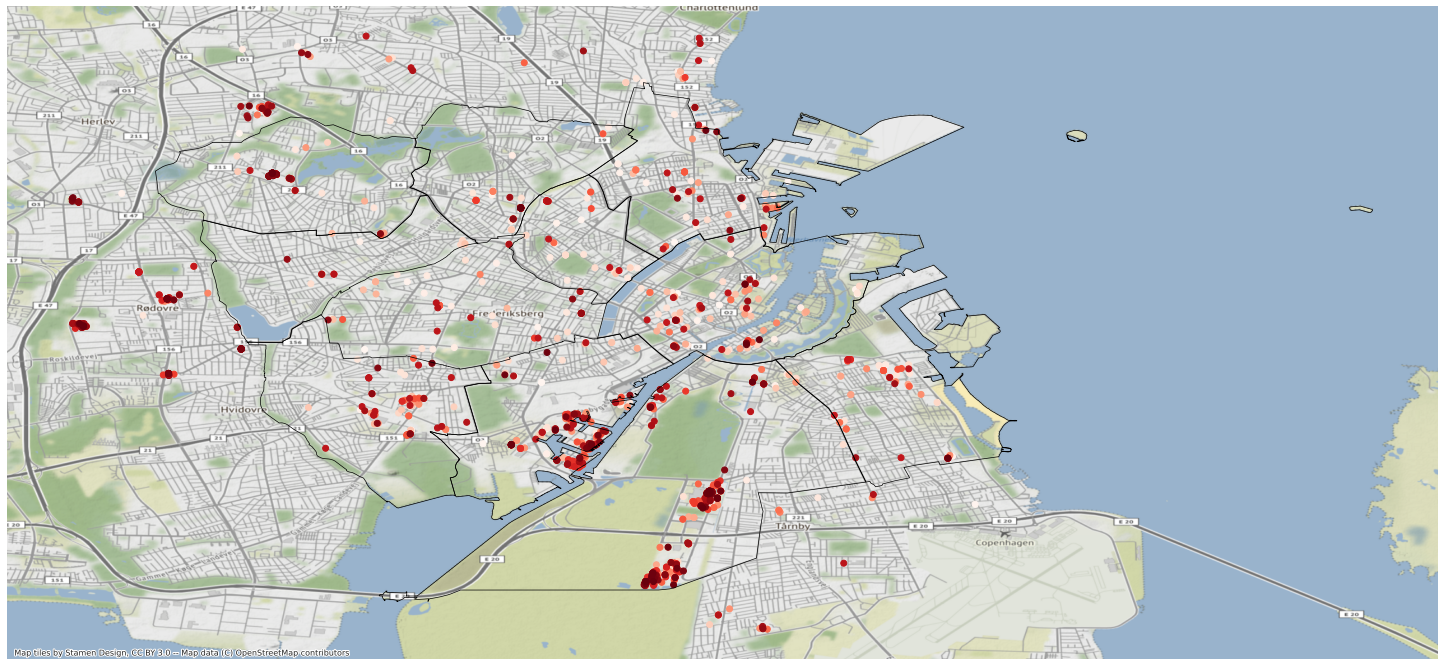

In [20]:
ax = gdf.plot(c=gdf["rent_norm"], cmap='Reds', legend=True) #color="black")
ax2 = cph_areas_bydel.plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)

ax.set_axis_off()
cx.add_basemap(ax, crs=gdf.crs)

cmap = plt.cm.get_cmap('cool')
cmap.set_under('red')

# Spatial Weights

### Block weights

In [21]:
joined = gpd.sjoin(gdf,cph_areas_bydel,how='left',op='within')

In [22]:
# Removing nan columns
joined_clean = joined.dropna(subset = ['index_right']).set_index('id_left')

In [23]:
joined_clean.head()

,rooms,area,rent,latitude,longitude,rent_norm,geometry,index_right,id_right,bydel_nr,navn,areal_m2,ogc_fid
id_left,,,,,,,,,,,,,
5248131,1,38,5216,55.652406,12.512200,137.263158,POINT (12.51220 55.65241),6.0,31.0,5.0,Valby,9235110.0,7
5211187,1,40,6300,55.649554,12.551497,157.500000,POINT (12.55150 55.64955),5.0,4.0,4.0,Vesterbro-Kongens Enghave,8327301.0,6
5263181,3,73,11000,55.663465,12.542260,150.684932,POINT (12.54226 55.66347),5.0,4.0,4.0,Vesterbro-Kongens Enghave,8327301.0,6
5249720,3,73,11000,55.663465,12.542260,150.684932,POINT (12.54226 55.66347),5.0,4.0,4.0,Vesterbro-Kongens Enghave,8327301.0,6
5142344,3,95,11000,55.695855,12.572995,115.789474,POINT (12.57300 55.69586),4.0,2.0,2.0,Østerbro,9858727.0,5


In [24]:
w_block = weights.block_weights(joined_clean['index_right'])

In [25]:
w_block.remap_ids(joined_clean.index)

In [26]:
# Row-based transformation
w_block.transform = 'R'

### Kernel weights

In [27]:
# With fixed distance band
#w_kernel = weights.distance.Kernel.from_dataframe(gdf, function='gaussian')

In [28]:
#w_kernel.remap_ids(gdf.index)

In [29]:
#w_kernel.bandwidth[0:5]

In [30]:
# Row-based transformation
#w_kernel.transform = 'R'

In [22]:
# Set apartment ID as df id
gdf = gdf.set_index("id")

Handle points on top of each other

In [23]:
# Caution: Removes apartments at same address
#gdf.drop_duplicates(subset=["latitude", "longitude"], inplace=True)

In [24]:
# Adding a small Gaussian on latitudes and longitudes
gdf_noise = gdf.copy()

gdf_noise['latitude'] = gdf_noise['latitude'].apply(lambda x: x + np.random.normal(0, 0.0001))
gdf_noise['longitude'] = gdf_noise['longitude'].apply(lambda x: x + np.random.normal(0, 0.0001))

gdf_noise = gpd.GeoDataFrame(gdf_noise, geometry=gpd.points_from_xy(gdf_noise.longitude,gdf_noise.latitude, crs="EPSG:4326"))

In [25]:
# With adaptive distance band

list_of_k = [2, 6, 8, 10]

w_adaptive_list = []

for k in list_of_k:
    w_adaptive = weights.distance.Kernel.from_dataframe(
        gdf_noise, fixed=False, k=k, function='gaussian'
    )
    
    w_adaptive.remap_ids(gdf_noise.index)
    w_adaptive_list.append(w_adaptive)

In [26]:
# Example: bandwith of first 5 points
w_adaptive_list[0].bandwidth[0:5]

array([[0.0004488 ],
       [0.00031544],
       [0.00318135],
       [0.00265508],
       [0.0014562 ]])

# Global spatial autocorrelation

## Block

In [37]:
# Non standardized spatial lag
joined_clean['w_rent_norm'] = weights.lag_spatial(w_block, joined_clean['rent_norm']) # we pass the weights object and the column with values to base the spatial lag on

In [38]:
joined_clean['rent_norm_std'] = (
    joined_clean['rent_norm'] - joined_clean['rent_norm'].mean()
) / joined_clean['rent_norm'].std()

In [39]:
joined_clean['w_rent_norm_std'] = weights.lag_spatial(w_block, joined_clean['rent_norm_std'])

In [40]:
joined_clean.head()

,rooms,area,rent,latitude,longitude,rent_norm,geometry,index_right,id_right,bydel_nr,navn,areal_m2,ogc_fid,w_rent_norm,rent_norm_std,w_rent_norm_std
id_left,,,,,,,,,,,,,,,,
5248131,1,38,5216,55.652406,12.512200,137.263158,POINT (12.51220 55.65241),6.0,31.0,5.0,Valby,9235110.0,7,186.394875,-0.768931,0.132997
5211187,1,40,6300,55.649554,12.551497,157.500000,POINT (12.55150 55.64955),5.0,4.0,4.0,Vesterbro-Kongens Enghave,8327301.0,6,167.620619,-0.397436,-0.211649
5263181,3,73,11000,55.663465,12.542260,150.684932,POINT (12.54226 55.66347),5.0,4.0,4.0,Vesterbro-Kongens Enghave,8327301.0,6,167.649620,-0.522543,-0.211116
5249720,3,73,11000,55.663465,12.542260,150.684932,POINT (12.54226 55.66347),5.0,4.0,4.0,Vesterbro-Kongens Enghave,8327301.0,6,167.649620,-0.522543,-0.211116
5142344,3,95,11000,55.695855,12.572995,115.789474,POINT (12.57300 55.69586),4.0,2.0,2.0,Østerbro,9858727.0,5,222.080762,-1.163131,0.788095


In [41]:
joined_clean[joined_clean["index_right"] == "Valby"]

,rooms,area,rent,latitude,longitude,rent_norm,geometry,index_right,id_right,bydel_nr,navn,areal_m2,ogc_fid,w_rent_norm,rent_norm_std,w_rent_norm_std
id_left,,,,,,,,,,,,,,,,


## Adaptive kernel

In [28]:
gdf_noise['rent_norm_std'] = (
    gdf_noise['rent_norm'] - gdf_noise['rent_norm'].mean()
) / gdf_noise['rent_norm'].std()

In [29]:
for i, k in enumerate(list_of_k):
    k_name = "w_rent_norm_std_k" + str(k)
    gdf_noise[k_name] = weights.lag_spatial(w_adaptive_list[i], gdf_noise['rent_norm_std'])

## Moran Plot

### Block

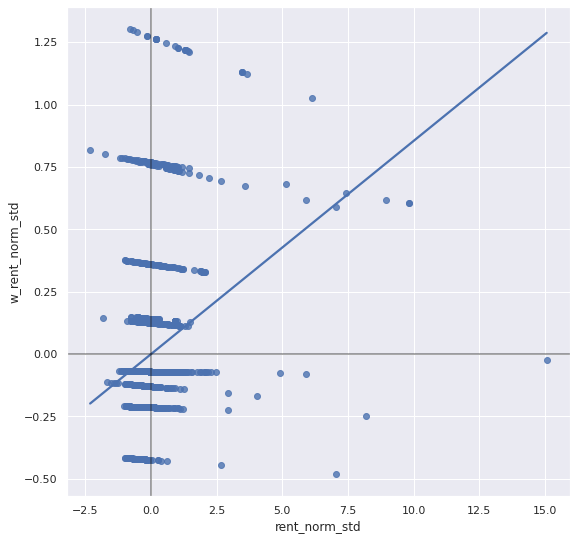

In [44]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='rent_norm_std', y='w_rent_norm_std', data=joined_clean, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

### Adaptive kernel

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


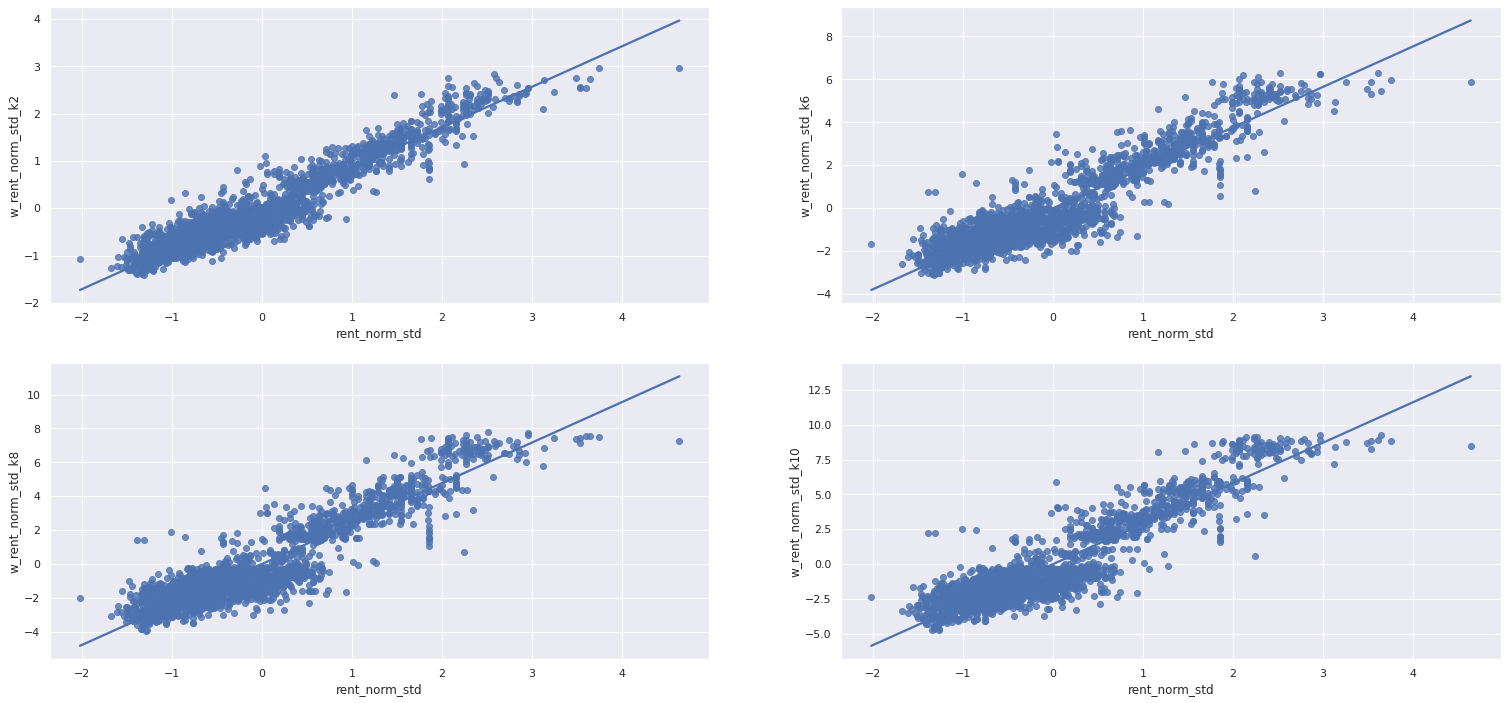

In [30]:
# Setup the figure and axis
#f, ax = plt.subplots(1, figsize=(9, 9))
f, axes = plt.subplots(2,2)
print(axes)
# Plot values

sns.regplot(ax=axes[0, 0], x='rent_norm_std', y="w_rent_norm_std_k2", data=gdf_noise, ci=None)
sns.regplot(ax=axes[0, 1], x='rent_norm_std', y="w_rent_norm_std_k6", data=gdf_noise, ci=None)
sns.regplot(ax=axes[1, 0], x='rent_norm_std', y="w_rent_norm_std_k8", data=gdf_noise, ci=None)
sns.regplot(ax=axes[1, 1], x='rent_norm_std', y="w_rent_norm_std_k10", data=gdf_noise, ci=None)
    # Add vertical and horizontal lines
    #plt.axvline(0, c='k', alpha=0.5)
    #plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

## Moran's I

### Block

In [46]:
mi = esda.Moran(joined_clean['rent_norm'], w_block)

In [47]:
mi.I

0.08547464587715389

In [48]:
mi.p_sim

0.001

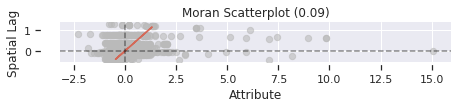

In [49]:
moran_scatterplot(mi);

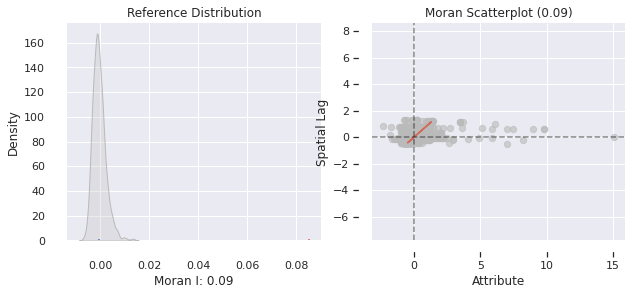

In [50]:
plot_moran(mi);

### Adaptive kernel

In [31]:
list_of_morans = []
for w in w_adaptive_list:
    mi = esda.Moran(gdf['rent_norm'], w)
    list_of_morans.append(mi)

In [32]:
for idx, m in enumerate(list_of_morans):
    print(list_of_k[idx])
    print(m.I, m.p_sim)

2
0.8998613585722827 0.001
6
0.8519626462406379 0.001
8
0.8435808636941696 0.001
10
0.8375077252766536 0.001


2
6
8
10


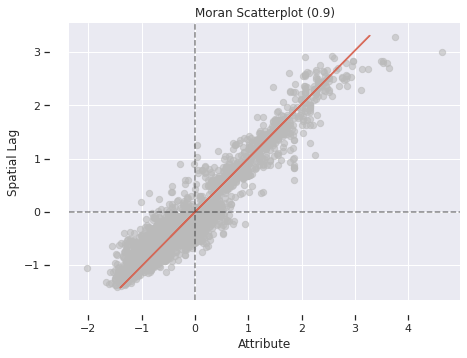

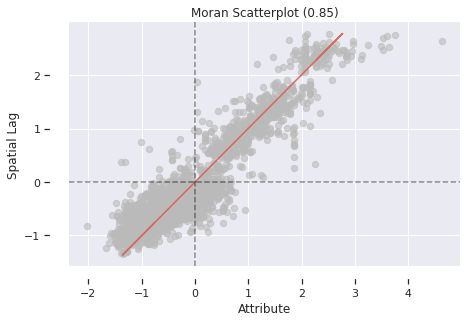

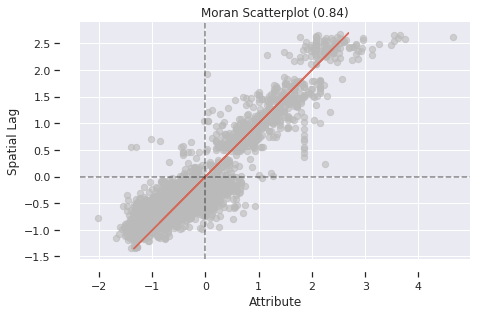

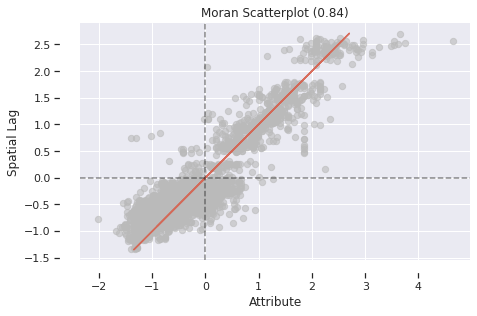

In [33]:
for idx, m in enumerate(list_of_morans):
    print(list_of_k[idx])
    moran_scatterplot(m);

2
6
8
10


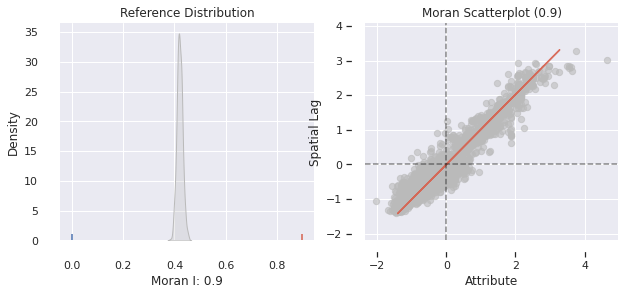

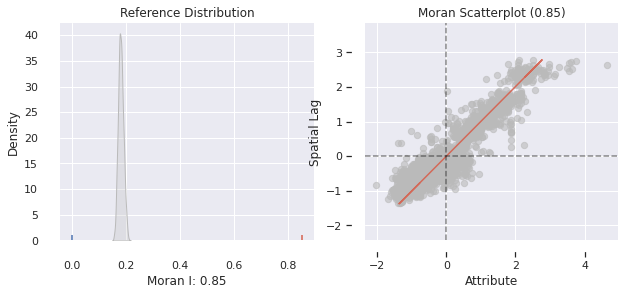

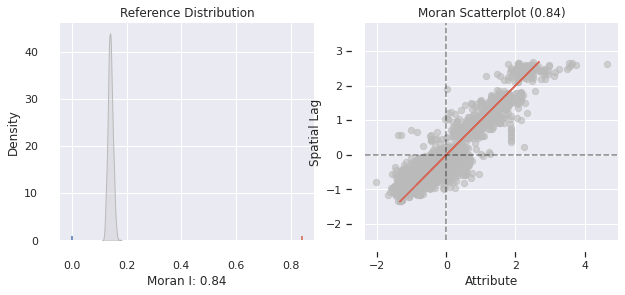

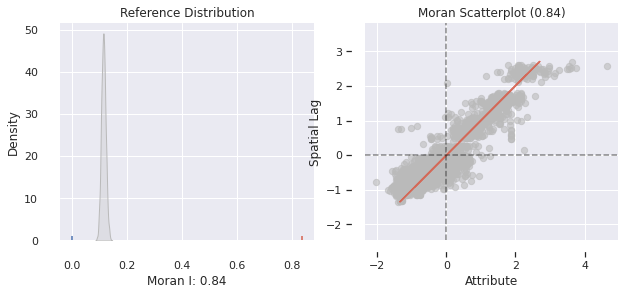

In [34]:
for idx, m in enumerate(list_of_morans):
    print(list_of_k[idx])
    plot_moran(m);